In [ ]:
#pip install torch torchvision

In [1]:
import os
import torch
import torch.nn as nn 
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.optim as opt
from torchvision import datasets, transforms, models
import torchvision
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
def get_data_set():

    transform_train = transforms.Compose([
        transforms.Resize((224,224)), 
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    

    transform_test = transforms.Compose([
        transforms.Resize((224,224)), 
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    train = datasets.CIFAR10(root='../data', train=True, download=True, transform=transform_train)
    test = datasets.CIFAR10(root='../data', train=False, download=True, transform=transform_test)

    
    return train, test

train, test = get_data_set()

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


In [3]:
BATCH_SIZE = 100 #原本為8

train_loader = DataLoader(train, batch_size= BATCH_SIZE, shuffle=True, num_workers= 0)
test_loader = DataLoader(test, batch_size= BATCH_SIZE, shuffle=False, num_workers= 0)


In [ ]:
train_loader.dataset,test_loader.dataset


(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: ../data
     Split: Train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
                RandomCrop(size=(224, 224), padding=None)
                ColorJitter(brightness=[0.5, 1.5], contrast=None, saturation=None, hue=None)
                RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ), Dataset CIFAR10
     Number of datapoints: 10000
     Root location: ../data
     Split: Test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ))

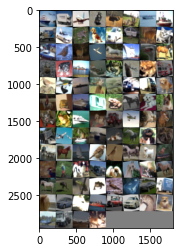

In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

    
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

In [4]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Ensemble Model

In [5]:
model_vgg16=models.vgg16(weights="DEFAULT")
model_resnet50=models.resnet50(weights="DEFAULT")
model_googlenet=models.googlenet(weights="DEFAULT")

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

In [6]:
for param in model_vgg16.parameters():
  param.requires_grad=False
for param in model_resnet50.parameters():
  param.requires_grad=False
for param in model_googlenet.parameters():
  param.requires_grad=False

In [7]:
model_vgg16.classifier=nn.Sequential(
     nn.Linear(in_features=25088, out_features=4096, bias=True),
     nn.ReLU(inplace=True),
     nn.Dropout(p=0.5, inplace=False),
     nn.Linear(in_features=4096, out_features=4096, bias=True),
     nn.ReLU(inplace=True),
     nn.Dropout(p=0.5, inplace=False),
     nn.Linear(in_features=4096, out_features=10, bias=True),
)
model_resnet50.fc=nn.Sequential(
     nn.Linear(in_features=2048, out_features=1024, bias=True),
     nn.ReLU(inplace=True),
     nn.Dropout(p=0.5, inplace=False),
     nn.Linear(in_features=1024, out_features=256, bias=True),
     nn.ReLU(inplace=True),
     nn.Dropout(p=0.5, inplace=False),
     nn.Linear(in_features=256, out_features=10, bias=True),
)
model_googlenet.fc=nn.Sequential(
     nn.Linear(in_features=1024, out_features=256, bias=True),
     nn.ReLU(inplace=True),
     nn.Dropout(p=0.5, inplace=False),
     nn.Linear(in_features=256, out_features=10, bias=True),
)

In [8]:
#要嘗試的組合: 1)accuracy 2)1/3 3)paper
wv = 85.73
wr = 76.60
wg = 74.13

In [9]:
weight_vgg16 = wv/(wv+wr+wg)
weight_resnet50 = wr/(wv+wr+wg)
weight_googlenet = wg/(wv+wr+wg)

In [10]:
model_vgg16=model_vgg16.cuda()
model_resnet50=model_resnet50.cuda()
model_googlenet=model_googlenet.cuda()

In [11]:
loss_fn=nn.CrossEntropyLoss()
optimizerV = opt.Adam(model_vgg16.classifier.parameters(), lr=1e-4)
lr_schedulerV = opt.lr_scheduler.ReduceLROnPlateau(optimizerV, factor=0.1, patience=3, verbose=True)

optimizerR=opt.Adam(model_resnet50.fc.parameters(),lr=0.0001)
optimizerG=opt.Adam(model_googlenet.fc.parameters(),lr=0.0005)

In [12]:
epoch_n=10

In [13]:
lossV_list = []
lossR_list = []
lossG_list = []
accu_list = []

for epoch in range(1, epoch_n+1):
  total_loss_vgg16 = 0.0
  total_loss_resnet50 = 0.0
  total_loss_googlenet = 0.0
  total_correct=0
  batch_num = 0

  for batch, (images,labels) in enumerate(train_loader,1):
    model_vgg16.train()
    
    images=Variable(images.cuda())
    labels=Variable(labels.cuda())

    y_pred_vgg16=model_vgg16(images)
    y_pred_resnet50=model_resnet50(images)
    y_pred_googlenet=model_googlenet(images)

    y_pred_e=(weight_vgg16*y_pred_vgg16)+(weight_resnet50*y_pred_resnet50)+(weight_googlenet*y_pred_googlenet)
    _,pred=torch.max(y_pred_e,1)

    optimizerV.zero_grad()
    optimizerR.zero_grad()
    optimizerG.zero_grad()

    loss_vgg16=loss_fn(y_pred_vgg16,labels)
    loss_vgg16.backward()

    loss_resnet50=loss_fn(y_pred_resnet50,labels)
    loss_resnet50.backward()

    loss_googlenet=loss_fn(y_pred_googlenet,labels)
    loss_googlenet.backward()

    optimizerV.step()
    optimizerR.step()
    optimizerG.step()

    total_loss_vgg16 += loss_vgg16.data
    total_loss_resnet50 += loss_resnet50.data
    total_loss_googlenet += loss_googlenet.data

    total_correct+=torch.sum(pred==labels.data)
    if batch%100==0:
      print("epoch:%d, batch:%d, loss_vgg16:%.4f, loss_resnet50:%.4f, loss_googlenet:%.4f, accuracy:%.4f"
                            %(epoch,batch,(total_loss_vgg16/batch),(total_loss_resnet50/batch),(total_loss_googlenet/batch),(total_correct/batch)))
      lossV_list.append(total_loss_vgg16/batch)
      lossR_list.append(total_loss_resnet50/batch)
      lossG_list.append(total_loss_googlenet/batch)
      accu_list.append(total_correct/batch)
      batch_num += 1

      lr_schedulerV.step(total_loss_vgg16/batch)

epoch:1, batch:100, loss_vgg16:0.9135, loss_resnet50:1.9633, loss_googlenet:1.5846, accuracy:70.1200
epoch:1, batch:200, loss_vgg16:0.7374, loss_resnet50:1.5927, loss_googlenet:1.2757, accuracy:76.8850
epoch:1, batch:300, loss_vgg16:0.6654, loss_resnet50:1.3874, loss_googlenet:1.1351, accuracy:79.7333
epoch:1, batch:400, loss_vgg16:0.6210, loss_resnet50:1.2590, loss_googlenet:1.0562, accuracy:81.4150
epoch:1, batch:500, loss_vgg16:0.5899, loss_resnet50:1.1734, loss_googlenet:1.0022, accuracy:82.4940
epoch:2, batch:100, loss_vgg16:0.2971, loss_resnet50:0.7655, loss_googlenet:0.7466, accuracy:90.9300
epoch:2, batch:200, loss_vgg16:0.2883, loss_resnet50:0.7471, loss_googlenet:0.7318, accuracy:91.1100
epoch:2, batch:300, loss_vgg16:0.2945, loss_resnet50:0.7405, loss_googlenet:0.7372, accuracy:90.9733
epoch:2, batch:400, loss_vgg16:0.2951, loss_resnet50:0.7306, loss_googlenet:0.7346, accuracy:91.0300
epoch:2, batch:500, loss_vgg16:0.2962, loss_resnet50:0.7188, loss_googlenet:0.7285, accurac

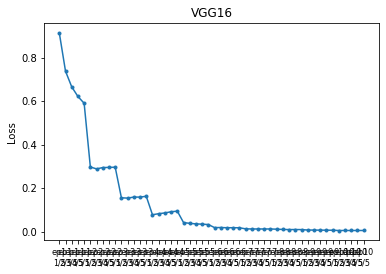

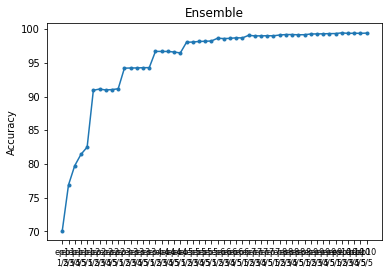

In [14]:
#如果圖畫出來很醜需要再微調
def draw(num_list, epochs, batch_num, y_label, title):
  x = range(len(num_list))
  plt.plot(x, num_list, '.-')

  labels = ['ep'+str(e)+'\n'+str(b)+'/'+str(batch_num) for e in range(1, epochs+1) for b in range(1, batch_num+1)]
  plt.xticks(ticks=x, labels=labels, rotation=0, fontsize=8) 

  plt.ylabel(y_label)
  plt.title(title)
  
  #plt.savefig(file_name)
  plt.show()

lossV_list = [i.cpu() for i in lossV_list]
draw(lossV_list, epoch_n, batch_num, 'Loss', 'VGG16')

accu_list = [i.cpu() for i in accu_list]
draw(accu_list, epoch_n, batch_num, 'Accuracy', 'Ensemble')

In [15]:
heatmap = pd.DataFrame(data=0, index=classes, columns=classes)

total_loss_vgg16 = 0.0
total_loss_resnet50 = 0.0
total_loss_googlenet = 0.0
total_correct=0

for batch, (images,labels) in enumerate(test_loader,1):
  model_vgg16.eval()

  images=Variable(images.cuda())
  labels=Variable(labels.cuda())

  y_pred_vgg16=model_vgg16(images)
  y_pred_resnet50=model_resnet50(images)
  y_pred_googlenet=model_googlenet(images)

  y_pred_e=(weight_vgg16*y_pred_vgg16)+(weight_resnet50*y_pred_resnet50)+(weight_googlenet*y_pred_googlenet)
  _,pred=torch.max(y_pred_e,1)

  for i in range(BATCH_SIZE):
    true_label = labels[i].item()
    pred_label = pred[i].item()
    heatmap.iloc[true_label, pred_label] += 1


  loss_vgg16=loss_fn(y_pred_vgg16,labels)

  loss_resnet50=loss_fn(y_pred_resnet50,labels)

  loss_googlenet=loss_fn(y_pred_googlenet,labels)


  total_loss_vgg16 += loss_vgg16.data
  total_loss_resnet50 += loss_resnet50.data
  total_loss_googlenet += loss_googlenet.data

  total_correct+=torch.sum(pred==labels.data)
  if batch%100==0:
    print(" batch:%d, loss_vgg16:%.4f, loss_resnet50:%.4f, loss_googlenet:%.4f, accuracy:%.4f"
                          %(batch,(total_loss_vgg16/batch),(total_loss_resnet50/batch),(total_loss_googlenet/batch),(total_correct/batch)))

 batch:100, loss_vgg16:0.6100, loss_resnet50:0.5657, loss_googlenet:0.6764, accuracy:90.6800


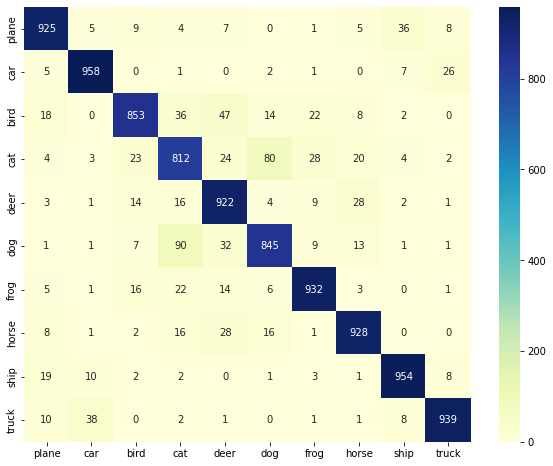

In [16]:
_, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(heatmap, annot=True, fmt="d", cmap="YlGnBu")
plt.show()